# Wet Day

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import folium

import numpy as np
import pandas as pd

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize


sys.path.append("../../../functions")
from data_downloaders import GHCN

In [3]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [4]:
df_country = GHCN.get_country_code(country)
print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

The GHCN code for Palau is PS


In [5]:
df_stations = GHCN.download_stations_info()
df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
print(f'There are {df_country_stations.shape[0]} stations in {country}')

There are 13 stations in Palau


In [6]:
GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
for var in vars_interest:
    globals()[f"dict_{var}"], IDS = GHCN.extract_dict_data_var(GHCND_dir, var, df_country_stations)

In [7]:
for var in vars_interest:
    
    dict_plot = globals()[f'dict_{var}']
    fig = plot_timeseries_interactive(dict_plot, trendline=False, ylims = [None, None], figsize = (25, 12))

## Using Koror Station

Analysis of wet days

In [8]:
id = 'PSW00040309' # Koror Station
dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]

In [9]:
fig = plot_timeseries_interactive(dict_prcp, trendline=True, ylims = [None, None], figsize = (25, 12))

## Wet days

In [10]:
data = dict_prcp[0]['data']#.dropna()
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

In [11]:
data['wet_day'] = np.where(data['PRCP'] > 0, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [12]:
import matplotlib.pyplot as plt

# Create the histogram

def plot_bar_probs(x, y, labels = None, figsize = [7, 5]):
    """
    Plots a bar chart showing the distribution of wet days.

    Parameters:
    x (list): The x-axis values for the bar chart.
    y (list): The y-axis values for the bar chart.
    labels (list, optional): The labels for the x-axis ticks. Defaults to None.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize = figsize)
    ax.bar(x = x, height = y, color=get_df_col()[0], edgecolor='white', alpha = .5)
    
    ax.set_ylabel('Frequency', fontsize = fontsize)
    if labels:
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize = fontsize)

    ax.grid(color = 'lightgrey', linestyle = ':', alpha = 0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    return ax


Text(0.5, 1.0, 'Distribution of Wet Days')

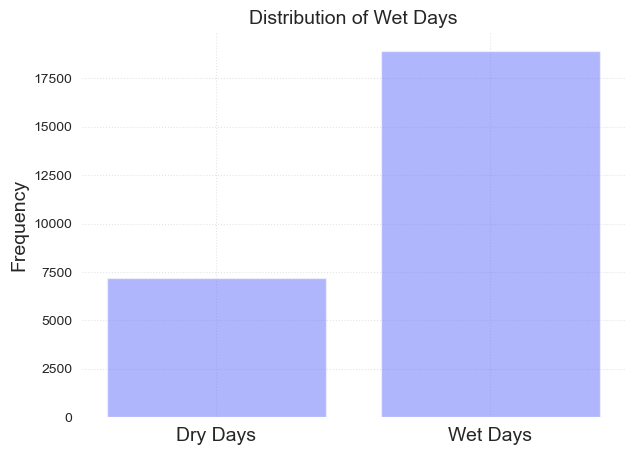

In [13]:
ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)


## Accumulated precipitation

In [14]:
# Correct accumulated precipitation with number of observations per year to make fair comparisons and trends
datag = (data.groupby(data.index.year).sum()/ data.groupby(data.index.year).count()) * 365
datag.index = pd.to_datetime(datag.index, format = '%Y')
dict_plot = [{'data' : datag, 'var' : 'PRCP', 'ax' : 1, 'label':'Accumulated precipitation [mm]'},]

In [15]:
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12));

Text(0.5, 1.0, 'Accumulated Rainfall Over Time')

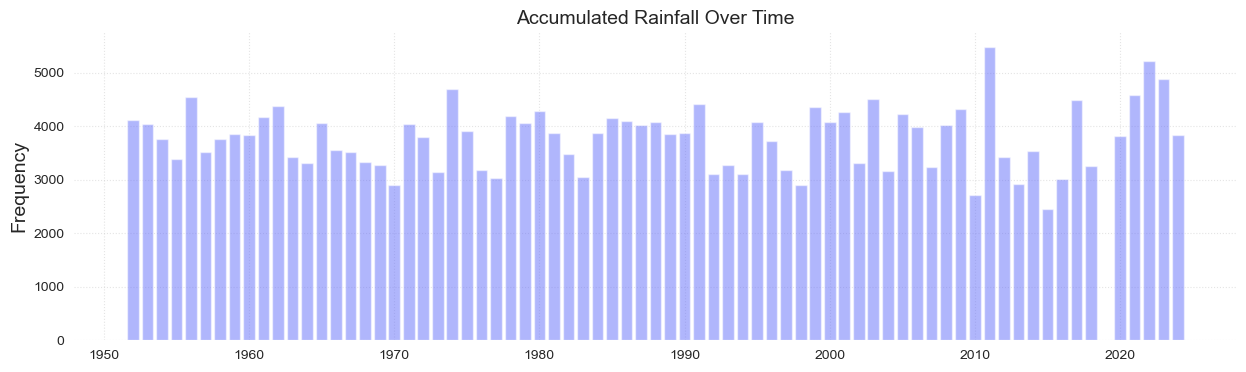

In [16]:
ax = plot_bar_probs(x = datag.index.year, y = datag['PRCP'].values, figsize = [15, 4])
ax.set_title('Accumulated Rainfall Over Time', fontsize = fontsize)


## Number of days over and above threshold

In [17]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [18]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

Text(0, 0.5, 'Number of days')

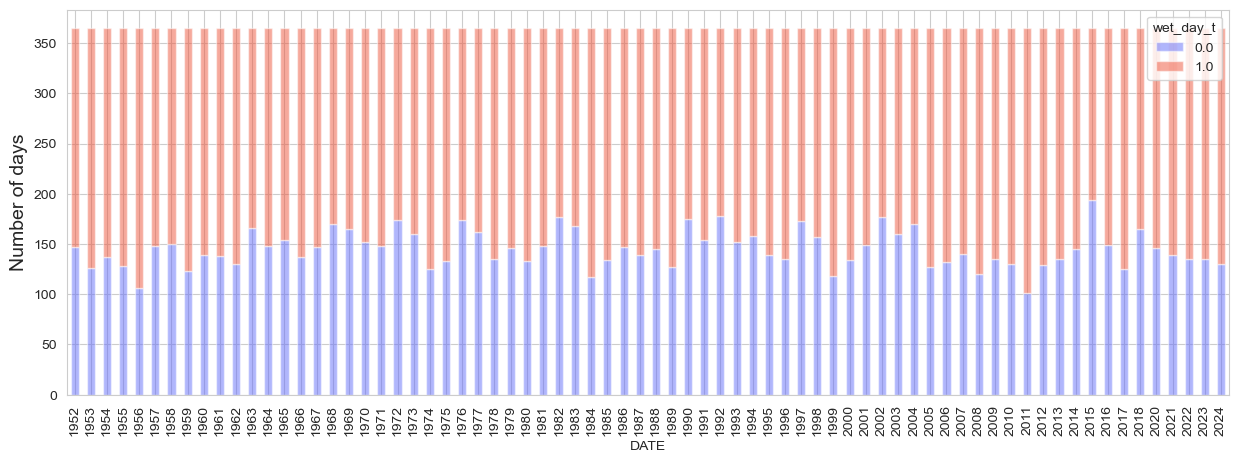

In [19]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

## Days over threshold

In [20]:
threshold = np.round(np.percentile(data['PRCP'].dropna(), 95), 2)
print(f'Threshold of {threshold}mm')
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Threshold of 45.7mm


In [21]:
data_2 = data.loc[data['wet_day_t'] == 1][['PRCP']]
data_over_th = data_2.groupby(data_2.index.year).count()
data_over_th.index = pd.to_datetime(data_over_th.index, format = '%Y')


In [22]:
data_over_th['PRCP_below'] = 365 - data_over_th['PRCP'].values

In [23]:
dict_plot = [{'data' : data_over_th, 'var' : 'PRCP', 'ax' : 1, 'label':f'Number of days over threshold: {threshold}mm'},]

In [24]:
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12));

In [25]:
dict_plot = [{'data' : data_over_th, 'var' : 'PRCP_below', 'ax' : 1, 'label':f'Number of days below threshold: {threshold}mm'}]

In [26]:
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12));